# Enzyme Project
## Cascade Plot
Hi my name is henri

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
fig4 <- read.csv("./rawdata/fig4b.csv")

In [3]:
fig4 %<>% rename(Buffer=A,t1=B, t2=C)

In [4]:
head(fig4)

,Distance,Buffer,t1,t2
1,0,0,0,0
2,1.8895,0,0,0
3,3.7791,0,0,0
4,5.6686,0,0,0
5,7.5581,0,0,0
6,9.4477,0,0,0


In [5]:
normal.vector <- colSums(fig4)/sum(fig4$Buffer)

Normalizing all data to a sum equal to sum of buffer normalized fliuorescence intensities

In [6]:
normal.vector[1] = 1

In [7]:
normal.vector

Distance   Buffer       t1       t2 
1.000000 1.000000 1.026655 1.113329

In [8]:
fig4 <- mapply("/",fig4,normal.vector)

In [9]:
colSums(fig4)

Distance      Buffer          t1          t2 
27464.38950    53.66266    53.66266    53.66266

In [10]:
fig4 <- as.data.frame(fig4)
head(fig4)

,Distance,Buffer,t1,t2
1,0,0,0,0
2,1.8895,0,0,0
3,3.7791,0,0,0
4,5.6686,0,0,0
5,7.5581,0,0,0
6,9.4477,0,0,0


In [11]:
# Putting data in tidy format
fig2m <- gather(fig4,"Experiment","Concentration",Buffer:t2)
head(fig2m)

,Distance,Experiment,Concentration
1,0,Buffer,0
2,1.8895,Buffer,0
3,3.7791,Buffer,0
4,5.6686,Buffer,0
5,7.5581,Buffer,0
6,9.4477,Buffer,0


Next we specify the model. The solution for our initial conditions is $a * erf(\frac{x-c}{\sqrt{4Dt}}) +b$, where $c$ is the step point at $t=0$, and $a$ and $b$ are determined by inital concentrations. As the geometry is also subject to noise, we add two offset parameters for the inital concentration profile (the locations of the channel limits).

We then fit the model using the `nls` R package. We also use the confidence intervals given by the package to fit the upper and lower bounds of the model.

In [12]:
erf <- function(x) 2*pnorm(x*sqrt(2)) -1
# fig2mgroup <- fig2m %>% group_by(variable)
# models <- list()
m <- function(df) {
    mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = df)
    pred <- fitted(mod)
    data.frame(df,pred)
    params = confint(mod, level= 0.95)
    cc <- coef(mod)
    l <- params[,1]
    u <- params[,2]
    lwr <- l[1]*(erf((df$Distance+l[2]-100)/sqrt(4*l[3])) - erf((df$Distance+u[4]-220)/sqrt(4*l[5])))
    upr <- u[1]*(erf((df$Distance+u[2]-100)/sqrt(4*u[3])) - erf((df$Distance+l[4]-220)/sqrt(4*u[5])))
    data.frame(df,pred,lwr,upr,cc[2],cc[4])
}
result <- fig2m %>% group_by(Experiment) %>% do(m(.))
models <- fig2m %>% group_by(Experiment) %>% do(model = nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = .))
library(plyr)
result <- rename(result,c("cc.2."="offsetleft","cc.4."="offsetright"))
glimpse(result)


Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initia

Observations: 513
Variables: 8
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.333022e-17, 1.599906e-16, 5.333022e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.296556e-1...
$ upr           (dbl) 2.147922e-16, 7.517726e-16, 2.362714e-15, 7.249236e-1...
$ offsetleft    (dbl) -7.945835, -7.945835, -7.945835, -7.945835, -7.945835...
$ offsetright   (dbl) 5.88404, 5.88404, 5.88404, 5.88404, 5.88404, 5.88404,...


In [13]:
#adding channel data
result$channel <- 0
result$channel[result$Distance <= 100] <- 'left'
result$channel[result$Distance > 100 & result$Distance <= 220] <- 'center'
result$channel[result$Distance > 220] <- 'right'
glimpse(result)

Observations: 513
Variables: 9
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.333022e-17, 1.599906e-16, 5.333022e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.296556e-1...
$ upr           (dbl) 2.147922e-16, 7.517726e-16, 2.362714e-15, 7.249236e-1...
$ offsetleft    (dbl) -7.945835, -7.945835, -7.945835, -7.945835, -7.945835...
$ offsetright   (dbl) 5.88404, 5.88404, 5.88404, 5.88404, 5.88404, 5.88404,...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [14]:
detach("package:plyr", unload=TRUE)

Warning message:
: ‘plyr’ namespace cannot be unloaded:
  namespace ‘plyr’ is imported by ‘scales’, ‘ggplot2’, ‘reshape2’, ‘broom’ so cannot be unloaded

In [15]:
groupy <- group_by(result,channel,Experiment)
summed <- summarise(groupy, pred = sum(pred), lwr = sum(lwr), upr = sum(upr), actual = sum(Concentration))
names(summed)[2] = 'experiment'
summed <- gather(summed, "variable","value", c(pred,actual))
summed$upr[summed$variable == 'actual'] <- NaN
summed$lwr[summed$variable == 'actual'] <- NaN

In [16]:
head(summed)

,channel,experiment,lwr,upr,variable,value
1,center,Buffer,51.47958,52.41124,pred,51.95167
2,center,t1,49.4759,50.67353,pred,50.08237
3,center,t2,47.70888,48.37319,pred,48.04369
4,left,Buffer,0.822626,1.085888,pred,0.9493709
5,left,t1,0.8801767,1.256757,pred,1.059575
6,left,t2,0.9970899,1.253593,pred,1.121683


Warning message:
: Removed 6 rows containing missing values (geom_errorbar).

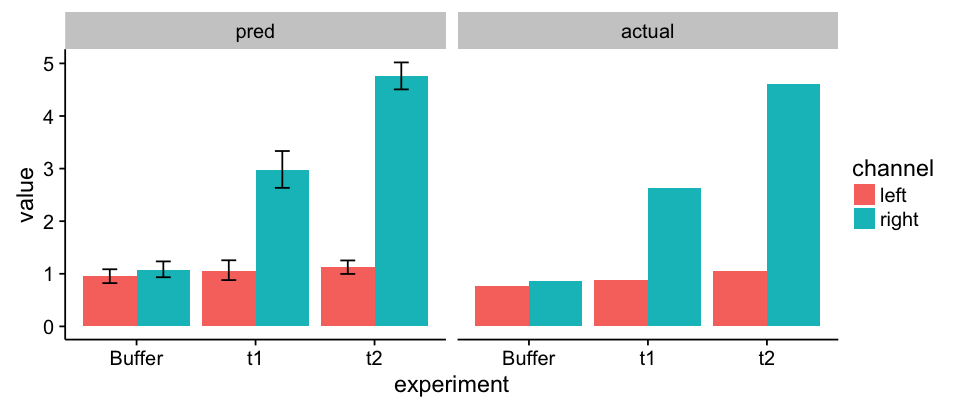

In [17]:
options(repr.plot.width = 8, repr.plot.height = 3.4)

a <- ggplot(data = subset(summed, channel != 'center'),aes(x=experiment, y=value, group = channel))
a <- a+geom_bar(stat='identity',position = "dodge", aes(fill = channel))
a <- a+geom_errorbar(aes(ymin = lwr, ymax =upr),position=position_dodge(width = 0.9),width = .25)
a + facet_grid(. ~ variable)

In [18]:
control.conc = filter(result, Experiment == 'Buffer')$Concentration
control.pred = filter(result, Experiment == 'Buffer')$pred
result %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()
result %<>% rename(Substrate = Experiment)

In [19]:
head(result)

,Distance,Substrate,Concentration,pred,lwr,upr,offsetleft,offsetright,channel,control.concentration,control.pred
1,0,Buffer,0,0,0,2.147922e-16,-7.945835,5.88404,left,0,0
2,1.8895,Buffer,0,5.333022e-17,0,7.517726e-16,-7.945835,5.88404,left,0,5.333022e-17
3,3.7791,Buffer,0,1.599906e-16,0,2.362714e-15,-7.945835,5.88404,left,0,1.599906e-16
4,5.6686,Buffer,0,5.333022e-16,5.296556e-17,7.249236e-15,-7.945835,5.88404,left,0,5.333022e-16
5,7.5581,Buffer,0,1.813227e-15,1.059311e-16,2.18551e-14,-7.945835,5.88404,left,0,1.813227e-15
6,9.4477,Buffer,0,5.812994e-15,4.237245e-16,6.454505e-14,-7.945835,5.88404,left,0,5.812994e-15


In [20]:
summed %<>% rename(Substrate = experiment)
control.conc <- filter(summed, Substrate == 'Buffer')$value
control.lwr <- filter(summed, Substrate == 'Buffer')$lwr
control.upr <- filter(summed, Substrate == 'Buffer')$upr
summed %<>% group_by(Substrate) %>% mutate(control.concentration = control.conc,control.lwr = control.lwr,
                                           control.upr = control.upr)
summed %<>% ungroup()


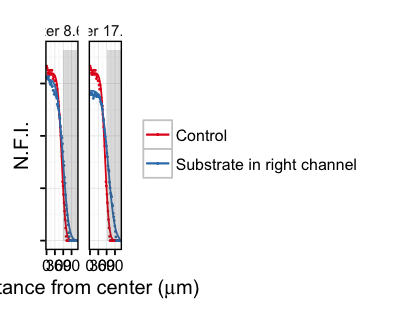

In [122]:
options(repr.plot.width = 3.3, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(result,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_line(aes(y = control.pred,color = cols[2])) +
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_point(size = 0.1) +
    geom_line(aes(y = pred)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in right channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(t1 = 'After 8.6 s',t2 = 'After 17.3 s'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)
#          legend.position='bottom') +
          )+
#     annotate("rect", xmin = xmin, xmax = -60, ymin = 0.000025, ymax = +1.00091, alpha = .2)
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +1.091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

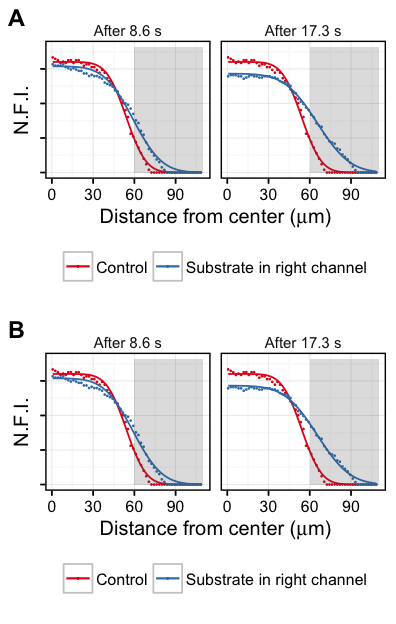

In [22]:
options(repr.plot.width = 3.3, repr.plot.height = 5.2)

plot_grid(raw,raw, labels = c("A","B"),ncol = 1)

In [23]:
ggsave("./img/CascadeEnhancedDiffusion.png",width = 3.3, height = 5.2)

Note: This plot is partial. I use Preview to cut out the 'A' and concatenate with the other plot for which I do not have the data. The other file name in the latest version is `Fig 4 slash.png`

### Redoing part 2 of the graph

In [66]:
cascade.DF <- read.csv("./rawdata/cascade_time.csv")

In [67]:
cascade.DF

,Experiment,Time,Enzyne,StDev
1,Glucose.Channel,14.4,12.05,3.8
2,Glucose.Channel,28.8,19.59,3.7
3,Glucose.Channel,43.2,28.51,0.3
4,Glucose.Channel,57.6,36.95,3
5,Glucose.Mannose.Channel,14.4,6.37,2
6,Glucose.Mannose.Channel,28.8,9.04,1.2
7,Glucose.Mannose.Channel,43.2,12.06,1
8,Glucose.Mannose.Channel,57.6,16.04,3.9
9,Ald,14.4,3.58,0.8
10,Ald,28.8,5.1,1.4


In [77]:
cascade.DF$Experiment <- factor(cascade.DF$Experiment,levels = c ('Glucose.Channel','Glucose.Mannose.Channel','Ald'))
cascade.DF$Time <- as.factor(cascade.DF$Time)

In [130]:
options(repr.plot.width = 5, repr.plot.height = 2)
barchart <- ggplot(data = cascade.DF , 
                     aes(x=Time, y= Enzyne,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())+
    geom_errorbar(aes(ymin = Enzyne-StDev,ymax = Enzyne+StDev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#377eb8","#a6cee3"),labels = 
                  c("HK in Glucose Channel","HK in Glu-Mannose Channel","Aldolase in Glucose Channel"))

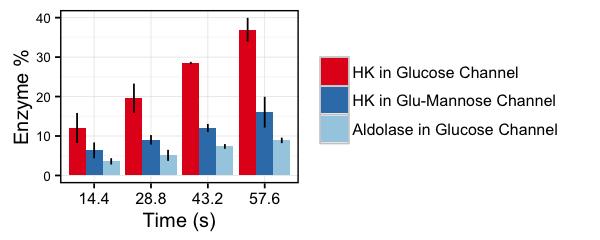

In [131]:
print(barchart)

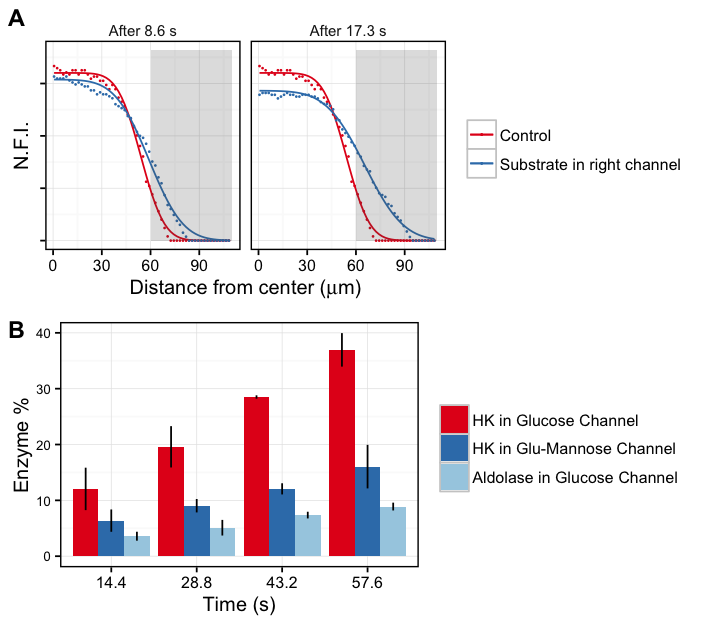

In [134]:
options(repr.plot.width = 6, repr.plot.height = 5.2)

plot_grid(raw,barchart, labels = c("A","B"),ncol = 1)

In [135]:
ggsave("./img/CascadeEnhancedDiffusionv2.png",width = 6, height = 5.2)

### Redoing graph 6

In [161]:
fig6.DF <- read.csv("./rawdata/fig6v2.csv")

Warning message:
In read.table(file = file, header = header, sep = sep, quote = quote, : incomplete final line found by readTableHeader on './rawdata/fig6v2.csv'

In [162]:
fig6.DF

,time,conc,experiment,stdev
1,43.2,5.25,hk,0.7
2,57.6,9.86,hk,1.4
3,43.2,1.99,ald,0.3
4,57.6,3.37,ald,1


In [163]:
fig6.DF$time <- as.factor(fig6.DF$time)
fig6.DF$experiment <- factor(fig6.DF$experiment,levels=c("hk","ald"))

In [172]:
options(repr.plot.width = 4.6, repr.plot.height = 2)
barchart2 <- ggplot(data = fig6.DF , 
                     aes(x=time, y= conc,fill = experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Time (s)") +
    ylab("Enzyme %") +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=8),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line())+
    geom_errorbar(aes(ymin = conc-stdev,ymax = conc+stdev ),position = position_dodge(.9), width = 0) +
scale_fill_manual(values = c ("#e41a1c","#377eb8"),labels = 
                  c("HK in Glucose Channel","Aldolase in Glucose Channel"))

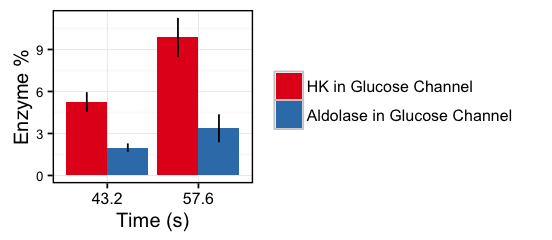

In [173]:
print(barchart2)

In [174]:
ggsave("./img/fig6v2.png",width = 4.6, height = 2)